# A BERT architecture exploration on downstream NLP tasks

**Imports**

In [1]:
import json
import math
from collections import OrderedDict
import torch
from torch import nn, Tensor
from typing import Union, Tuple, List, Iterable, Dict
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import AdamW
from torch.utils.data import DataLoader
from scipy.stats import pearsonr, spearmanr
import numpy as np
import gzip, csv
import pandas as pd
from tqdm.auto import tqdm

torch.manual_seed(0)
np.random.seed(0)

In [2]:
%pip install transformers
from transformers import AutoTokenizer
# If you can not find all the bugs, use the line below for AutoModel
from transformers import AutoModel

In [3]:
def gelu(x):

    """
    Applies de Gaussian Error Linear Unit activation function.

    Args:
      x (Tensor): Input tensor.

    Returns:
      Tensor: Output tensor with the same shape as the input tensor.
    """

    # uses torch.erf() to compute the error function of each element in x
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

# Bug 1: lower the value of dropout_prob to something smaller like 0.1, which is a standard value
class Config(object):
    def __init__(self,
                vocab_size,
                hidden_size=768,
                num_hidden_layers=12,
                num_attention_heads=12,
                intermediate_size=3072,
                dropout_prob=0.1, # This was 0.9 which could lead to underfitting and is unusually high
                max_position_embeddings=512,
                type_vocab_size=2,
                initializer_range=0.02):

        """
        Configuration initialization for BERT.

        Args:
            vocab_size (int): Vocabulary size.
            hidden_size (int): Size of the hidden layers in the transformer.
            num_hidden_layers (int): Number of hidden layers in the transformer encoder.
            num_attention_heads (int): Number of attention heads in the attention mechanism.
            intermediate_size (int): The size of the "intermediate" layer (i.e, feed-forwars)
            dropout_prob (float): The dropout probability for all fully connected layers in the embeddings and encoder.
            max_position_embeddings (int): Maximum sequence length that this model might ever be used with.
            type_vocab_size (int): The vocabulary size of the `token_type_ids` passed when calling `BertModel`.
            initializer_range (float): The std of the truncated_normal_initializer for initializing all weight matrices.

        The arguments passed will be set as the model attributes.
        """

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = dropout_prob
        self.attention_probs_dropout_prob = dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

        assert self.hidden_size % self.num_attention_heads == 0, "hidden_size must be divisible by num_attention_heads"

    @classmethod
    def from_dict(cls, dict_object):

        """
        Creates a Config object from a dictionary object.

        Args:
            dict_object (Dict): A dictionary containing the config parameters.

        Returns:
            Config: Config object.
        """

        config = Config(vocab_size=None)
        for (key, value) in dict_object.items():
            config.__dict__[key] = value
        return config

# Bug 2: LayerNorm forward() was operating x = x+u ... when it should be x-u as for the original formula: y = (x - E[x]) / (Var[x] + eps) * gamma + beta
class LayerNorm(nn.Module):
      def __init__(self, hidden_size, variance_epsilon=1e-12):

        """
        Initializes the Layer Normalization module.

        Args:
            hidden_size (int): Dimensiontality of the input.
            variance_epsilon (float): A small float added to the variance to avoid division by zero.
        """

        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon
        nn.init.ones_(self.gamma)
        nn.init.zeros_(self.beta) # These two lines aim to improve the models performance to reach expected correlations

      def forward(self, x):

        """
        Forward pass for Layer Normalization.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Normalized tensor.
        """

        #u = x.mean(0, keepdim=True)
        u = x.mean(-1, keepdim=True) # This should work to operate over the feature dimension
        # s = (x + u).pow(2).mean(0, keepdim=True)
        # x = (x + u) / torch.sqrt(s + self.variance_epsilon)
        # s = (x - u).pow(2).mean(0, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True) # operate over the same dimension
        x = (x - u) / torch.sqrt(s + self.variance_epsilon) # Uses a mean-substracted input, x+u would normalize features incorrectly
        return self.gamma * x + self.beta

# Bug 3: the gelu activation func was being applied during the contraction layer when it should be applied before
class MLP(nn.Module):
      def __init__(self, hidden_size, intermediate_size):

        """
        Initializes the Multi-Layer Perceptron module

        Args:
            hidden_size (int): Dimensionality of the input.
            intermediate_size (int): Dimensionality of the intermediate layer.
        """

        # MLP consisting of expansion and contraction layers
        super(MLP, self).__init__()
        self.dense_expansion = nn.Linear(hidden_size, intermediate_size)
        self.dense_contraction = nn.Linear(intermediate_size, hidden_size)

      def forward(self, x):

        """
        Forward pass for the MLP.

        Args:
            x (Tensor): Input tensor.

        Return:
            Tensor: Output tensor.
        """

        x = self.dense_expansion(x)
        # x = self.dense_contraction(gelu(x))
        x = gelu(x) # It's common practice to apply the activation function right after expansion for MLP
        x = self.dense_contraction(x)
        return x

# Bug 4: float('inf') for the attention mask may cause numerical inestability, its better to use -1e9
# Bug 5: split_heads and merge_heads were not considering the batch size, which lead to wrong reshaping
# Bug 7: not all layer's in Bert's forward function were receiving the attention_mask which is essential for the attention mechanism
class Layer(nn.Module):
    def __init__(self, config):

        """
        Initializes a transformer layer.

        Args:
            config (Config): Config object containing the parameter settings for the implementation.
        """

        # Single transformer layer consisting of multi-head attention and feed-forward neural network.
        super(Layer, self).__init__()

        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        self.attn_out = nn.Linear(config.hidden_size, config.hidden_size)
        self.ln1 = LayerNorm(config.hidden_size)

        self.mlp = MLP(config.hidden_size, config.intermediate_size)
        self.ln2 = LayerNorm(config.hidden_size)

    def split_heads(self, tensor, batch_size, num_heads, attention_head_size):

        """
        Splits the last dimension of tensor into (num_heads, attention_head_size).

        Conceptual Note on Attention Heads:
            In multi-head attention, the model runs through the attention mechanism
            multiple times in parallel. The key, query and value for each "head"
            are different, learned projections. This allows the model to focus on
            different parts of the input for different tasks or reasoning processes.
            (This note was added for self clarification of concepts)

        Args:
            tensor (Tensor): Tensor to be reshaped, usually a Query, Key or Value tensor.
            batch_size (int): The size of the batch of the input tensor.
            num_heads (int): Number of attention heads .
            attention_head_size (int): Size of each attention head.

        Returns:
            Tensor: Reshaped tensor.
        """

        #new_shape = tensor.size()[:-1] + (num_heads, attention_head_size)
        new_shape = (batch_size, -1, num_heads, attention_head_size) # This should help with the shape errors
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)

    def merge_heads(self, tensor, batch_size, num_heads, attention_head_size):

        """
        Merges the attention heads into a single set of hidden states.

        Conceptual Note on Merging Heads:
            After the attention scores have been calculated individually for each
            head, the results are concatenated and projected back to the original
            hidden state dimensions. This helps in capturing various aspects of the
            relationships between different words in the input.
            (Just like with split_heads(), this note was added for self clarification)

        Args:
            tensor (Tensor): The tensor to be reshaped.
            batch_size (int): The size of the batch of the input tensor.
            num_heads (int): Number of attention heads.
            attention_head_size (int): Size of each attention head.

        Returns:
            Tensor: Reshaped tensor.
        """

        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        #new_shape = tensor.size()[:-2] + (num_heads * attention_head_size,)
        new_shape = (batch_size, -1, num_heads * attention_head_size) # We need to consider the batch size when splitting and merging heads
        return tensor.view(new_shape)

    def attn(self, q, k, v, attention_mask):

        """
        Computes the self-attention mechanism.

        Args:
            q (Tensor): Query tensor.
            k (Tensor): Key tensor.
            v (Tensor): Value tensor.
            attention_mask (Tensor): Mask to avoid attention to certain positions.

        Returns:
            Tensor: Tensor resulting from the attention mechanism.
        """

        mask = attention_mask == 1
        mask = mask.unsqueeze(1).unsqueeze(2)

        # s = torch.matmul(q, k)
        s = torch.matmul(q, k.transpose(-1, -2)) # transposing the key should help to keep dot product working well
        s = s / math.sqrt(self.attention_head_size)

        # s = torch.where(mask, s, torch.tensor(float('inf')))
        # s = torch.where(mask, s, torch.tensor(-1e9).to(s.dtype)) # To keep numerical stability in gradients and avoid backpropagating errors during training
        s.masked_fill_(~mask, -1e9) # This should also help with performance as masked_fill_ is a PyTorch built-in function

        #p = s
        p = F.softmax(s, dim=-1) # Pass the attention scores through a softmax function where -1e9 is a mask that avoid undefining very small values
        p = self.dropout(p)

        a = torch.matmul(p, v)
        return a

    def forward(self, x, attention_mask):

        """
        Forward pass for each transformer layer

        Args:
            x (Tensor): Input tensor
            attention_mask (Tensor): Mask to avoid attention to certain positions.

        Returns:
            Tensor: Tensor resulting from the transformer layer.
        """

        batch_size = x.size(0)

        q, k, v = self.query(x), self.key(x), self.value(x)

        q = self.split_heads(q, batch_size, self.num_attention_heads, self.attention_head_size) # Remember we changed the function to add an argument
        k = self.split_heads(k, batch_size, self.num_attention_heads, self.attention_head_size)
        v = self.split_heads(v, batch_size, self.num_attention_heads, self.attention_head_size)

        a = self.attn(q, k, v, attention_mask)
        a = self.merge_heads(a, batch_size, self.num_attention_heads, self.attention_head_size) # Here too

        a = self.attn_out(a)
        a = self.dropout(a)
        a = self.ln1(a + x)

        m = self.mlp(a)
        m = self.dropout(m)
        m = self.ln2(m + a)

        return m

# Bug 6: Fixed the embeddings to sum them instead of concatenating them
class Bert(nn.Module):

      # BERT model made of embedding and multiple transformer layers.
      def __init__(self, config_dict):

        """
        Initializes the BERT model.

        Args:
            config_dict (Dict): Dictionary containing the model's parameters.
        """

        super(Bert, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.embeddings = nn.ModuleDict({
          'token': nn.Embedding(self.config.vocab_size, self.config.hidden_size, padding_idx=0),
          'position': nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size),
          'token_type': nn.Embedding(self.config.type_vocab_size, self.config.hidden_size),
        })

        self.ln = LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)

        self.layers = nn.ModuleList([
            Layer(self.config) for _ in range(self.config.num_hidden_layers)
        ])

        self.pooler = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.config.hidden_size, self.config.hidden_size)),
            ('activation', nn.Tanh()),
        ]))

      def forward(self, input_ids, attention_mask=None, token_type_ids=None,): # Let's try removing the extra comma

        """
        Forward pass for the BERT model.

        Args:
            input_ids (Tensor): Tensor of token ids.
            attention_mask (Tensor, optional): Attention mask values (1 or 0).
            token_type_ids (Tensor, optional): Segment token indices to indicate first and second portions of the inputs.

        Returns:
            Tuple[Tensor, Tensor]: Tuple containing the output of the model and the pooled output.
        """

        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # x = torch.cat((self.embeddings.token(input_ids),
        #                self.embeddings.position(position_ids),
        #                self.embeddings.token_type(token_type_ids)),
        #               dim=-1) # This might give dimensionality inconsistence

        # This helps to keep the dimensionality of the embeddings
        x = (self.embeddings.token(input_ids) +
             self.embeddings.position(position_ids) +
             self.embeddings.token_type(token_type_ids)) # In BERT's original structure this was a design choice which I wanted to try and test
        x = self.dropout(self.ln(x))

        for layer in self.layers:
            x = layer(x, attention_mask)

        o = self.pooler(x[:, 0])
        return (x, o)

      def load_model(self, path):

        """
        Do you really need an explanation on what this method is used for?

        Args:
            path (str): The path to your pretrained model
        """

        self.load_state_dict(torch.load(path))
        return self

**Download weights for the custom Bert**

In [4]:
!wget https://github.com/for-ai/bert/raw/master/bert_tiny.bin

--2023-11-30 02:48:20--  https://github.com/for-ai/bert/raw/master/bert_tiny.bin
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin [following]
--2023-11-30 02:48:20--  https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17555010 (17M) [application/octet-stream]
Saving to: ‘bert_tiny.bin’

bert_tiny.bin       100%[===================>]  16.74M  --.-KB/s    in 0.1s    

2023-11-30 02:48:22 (135 MB/s) - ‘bert_tiny.bin’ saved [17555010/17555010]



**An example use of pretrained BERT with transformers library to encode a sentence**

In [5]:
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## IF YOU CANNOT SOLVE PREVIOUS BUGS, USE THE LINE BELOW:
bert = AutoModel.from_pretrained(MODEL_NAME)

#bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
#bert = Bert(bert_config).load_model('bert_tiny.bin')

#EXAMPLE USE
sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output = bert(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)

# We use "pooler_output" for simplicity. This corresponds the last layer
# hidden-state of the first token of the sequence (CLS token) after
# further processing through the layers used for the auxiliary pretraining task.
embedding = output[1]
print(f'\nResulting embedding shape: {embedding.shape}')
print(f'\nEmbedding datatype: {embedding.dtype}')

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]


Resulting embedding shape: torch.Size([1, 128])

Embedding datatype: torch.float32


**Semantic Textual Similarity (STS) benchmark:**
STS dataset consists of a set of sentence pairs with a semantic similarity scores for each pair. We want to use this dataset to evaluate the quality of a sentence encoder.

Dataset includes:

*   Sentence pair: (sentence1, sentence2)
*   Similarity score: ranging 1 to 5 where 5 corresponds highest similarity
*   Splits: train, dev, test

**Download datasets**

In [6]:
!wget https://sbert.net/datasets/stsbenchmark.tsv.gz

--2023-11-30 02:48:35--  https://sbert.net/datasets/stsbenchmark.tsv.gz
Resolving sbert.net (sbert.net)... 188.114.97.0, 188.114.96.0, 2a06:98c1:3120::, ...
Connecting to sbert.net (sbert.net)|188.114.97.0|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz [following]
--2023-11-30 02:48:36--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392336 (383K) [application/octet-stream]
Saving to: ‘stsbenchmark.tsv.gz’

stsbenchmark.tsv.gz 100%[===================>] 383.14K  --.-KB/s    in 0.04s   

2023-11-30 02

In [7]:
data = pd.read_csv('stsbenchmark.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


In [8]:
# Disable the SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# This one should be working now
def load_sts_dataset(file_name):

  # Read the file to a df (I've been trying for a while, there's something wrong with some of the data in the file)
  data = pd.read_csv(file_name, compression='gzip', delimiter='\t', quoting=csv.QUOTE_NONE, engine='python') # Using python's built-in csv parser I found there was an error within quotations

  # Filter out only the test data
  test_data = data[data['split'] == 'test']

  ### This pseudo data processing did nothing to help raise the correlation
  # # I'll try lowercasing to check if it helps with the metrics
  # test_data['sentence1'] = test_data['sentence1'].str.lower()
  # test_data['sentence2'] = test_data['sentence2'].str.lower()

  # Create a dictionary with tuples with the sentence1, sentence2 and the score
  sts_samples = {'test': list(zip(test_data['sentence1'], test_data['sentence2'], test_data['score']))}

  return sts_samples

def tokenize_sentence_pair_dataset(dataset, tokenizer, max_length=512):

  tokenized_dataset = []
  for sentence1, sentence2, score in dataset:

    #print(f"sentence 1: {sentence1}, \nsentence 2: {sentence2}, \nscore: {score}\n")

    tokens1 = tokenizer(sentence1, return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)
    tokens2 = tokenizer(sentence2, return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)

    #print(f"tokens 1 (squeezed) is \n{tokens1['input_ids'].squeeze(0)} \ntokens 2 (squeezed) is \n{tokens2['input_ids'].squeeze(0)}")
    #print(f"tokens 1 () is \n{tokens1['input_ids']} \ntokens 2 () is \n{tokens2['input_ids']}")
    #break

    tokenized_dataset.append(
        (tokens1['input_ids'].squeeze(0), tokens1['attention_mask'].squeeze(0),
         tokens2['input_ids'].squeeze(0), tokens2['attention_mask'].squeeze(0), # This function wasn't working until I noticed I wrote 'attention mask' instead of 'attention_mask'
         score)
    )
  return tokenized_dataset


def get_dataloader(tokenized_dataset, batch_size, shuffle=False):
  return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle)


def cosine_sim(a, b):

  # TODO: Implement cosine similarity function **from scrach**:
  # This method should expect two 2D matrices (batch, vector_dim) and
  # return a 2D matrix (batch, batch) that contains all pairwise cosine similarities
  norm_a = torch.norm(a, dim=-1, keepdim=True) # I dared to use torch.norm because it will be faster than implementing norm by myself
  norm_b = torch.norm(b, dim=-1, keepdim=True)
  dot_product = torch.matmul(a, b.T) # Lol, it's not .transpose(), it's torch.T and it's not a method. I confused
  return dot_product / (norm_a * norm_b.T)


def eval_loop(model, eval_dataloader, device):
  #TODO: add code to for evaluation loop
  #TODO: Use cosine_sim function above as distance metric for pearsonr and spearmanr functions that are imported
  all_scores = []
  all_preds = []
  for batch in eval_dataloader:
    input_ids1, attention_mask1, input_ids2, attention_mask2, scores = batch
    with torch.no_grad():
      output1 = model(input_ids1.to(device), attention_mask=attention_mask1.to(device))[1]
      output2 = model(input_ids2.to(device), attention_mask=attention_mask2.to(device))[1]
      assert output1.shape == output2.shape # Raises an error if there is some problem with the dimensions, for debugging
    cosine_scores = cosine_sim(output1, output2).cpu().numpy()
    #print(f"Cosine score for {batch} is {cosine_scores}") #This was not a good idea
    all_scores.extend(scores.cpu().numpy())
    #all_preds.extend(cosine_scores) # I'll try to squeeze before extending to avoid getting a constant list
    all_preds.append(cosine_scores.squeeze())
    #all_preds.extend(np.expand_dims(cosine_scores.squeeze(), axis=0)) # I thought this dimensionality play would help with the performance, but didn't

  all_preds = np.array(all_preds).reshape(-1,)

  print(f"Shape of all_scores is {np.array(all_scores).shape}, \nshape of all_preds is {np.array(all_preds).shape}")

  # # I'm getting a 'constant array' warning, let's see if this solves the problem
  # print("All Scores:", all_scores)
  # # create a boolean array that indicates which elements are NaN
  # nan_mask = np.isnan(all_scores)
  # # count the number of True values in the boolean array
  # nan_count = np.count_nonzero(nan_mask)
  # print(f"All Scores has nan? {nan_count > 0}")

  # print("\nAll Predictions:", all_preds)
  # # create a boolean array that indicates which elements are NaN
  # nan_mask = np.isnan(all_preds)
  # # count the number of True values in the boolean array
  # nan_count = np.count_nonzero(nan_mask)
  # print(f"All Scores has nan? {nan_count > 0}")

  eval_pearson_cosine = pearsonr(all_preds, all_scores)[0]
  eval_spearman_cosine = spearmanr(all_preds, all_scores)[0]

  return [eval_pearson_cosine, eval_spearman_cosine]

**Evaluation**

Expected result:

Pearson correlation: 0.32

Spearman correlation: 0.33

In [11]:
#INFO: model and tokenizer
#model_name = 'prajjwal1/bert-tiny'
#tokenizer = AutoTokenizer.from_pretrained(model_name)

#INFO: load bert
#bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
#ert = Bert(bert_config).load_model('bert_tiny.bin')
bert = AutoModel.from_pretrained(MODEL_NAME)

#INFO: load dataset
sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')

#INFO: tokenize dataset
tokenized_test = tokenize_sentence_pair_dataset(sts_dataset['test'], tokenizer)

#INFO: generate dataloader
test_dataloader = get_dataloader(tokenized_test, batch_size=1)

In [12]:
#INFO: run evaluation loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Just to make sure the model is on the GPU (when available)
bert = bert.to(device)

results_from_pretrained = eval_loop(bert, test_dataloader, device)

print(f'\nPearson correlation: {results_from_pretrained[0]:.2f}\nSpearman correlation: {results_from_pretrained[1]:.2f}')

Shape of all_scores is (1379,), 
shape of all_preds is (1379,)

Pearson correlation: 0.32
Spearman correlation: 0.33


**A note on the results:**

As I used the pretrained model, it showed two things:
1. Though some debugs were spotted, not all of them might have been correctly fixed as the correlations with the locally defined model were between 0.16-0.22 but the pretrained model reached the desired correlations.
2. The utility functions are working fine as the encodings or the pretrained model give the desired results.

## Tests and debugging

In [ ]:
# testing = load_sts_dataset('stsbenchmark.tsv.gz')
# print(len(testing)), testing['test'][:5]

In [ ]:
a = torch.tensor([[1.0, 0.0], [0.0, 1.0]], device=device)
b = torch.tensor([[0.0, 1.0], [1.0, 0.0]], device=device)
print(cosine_sim(a, b))


tensor([[0., 1.],
        [1., 0.]], device='cuda:0')


In [ ]:
sts_dataset['test'][:5]

[('A girl is styling her hair.', 'A girl is brushing her hair.', 2.5),
 ('A group of men play soccer on the beach.',
  'A group of boys are playing soccer on the beach.',
  3.6),
 ("One woman is measuring another woman's ankle.",
  "A woman measures another woman's ankle.",
  5.0),
 ('A man is cutting up a cucumber.', 'A man is slicing a cucumber.', 4.2),
 ('A man is playing a harp.', 'A man is playing a keyboard.', 1.5)]

In [ ]:
# Get the first batch of data and labels from the dataloader object
input_ids1, attention_mask1, input_ids2, attention_mask2, scores = next(iter(test_dataloader))

# Print the shape of the data and labels tensors
print(input_ids1)
print(input_ids1.shape)
print(attention_mask1)
print(attention_mask1.shape)
print(input_ids2)
print(input_ids2.shape)
print(attention_mask2)
print(attention_mask2.shape)
print(scores.shape)

tensor([[  101,  1037,  2611,  2003, 20724,  2014,  2606,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
### THIS CODE IS ONLY FOR DEBUGGING

sentences = ['This is the first sentence.', "Lucas likes eating bread."]

bert.to("cpu")

tokenized_samples = [tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
for sentence in sentences]

embeddings = [bert(input_ids=sample['input_ids'], attention_mask=sample['attention_mask'])[1]
              for sample in tokenized_samples]

for i, emb in enumerate(embeddings):
  print(f"Embedding for sentence {i+1} has shape {emb.shape}")
  print(f"Tensor's first 10 elements: {emb[0][:10]}")

#tokenized_samples[:]

Embedding for sentence 1 has shape torch.Size([1, 128])
Tensor's first 10 elements: tensor([-1.0000,  0.0327, -0.9998, -0.0880, -0.9989, -0.2816, -0.9894, -0.8830,
         0.0346, -0.0654], grad_fn=<SliceBackward0>)
Embedding for sentence 2 has shape torch.Size([1, 128])
Tensor's first 10 elements: tensor([-1.0000, -0.0868, -0.9998,  0.9837, -0.9996,  0.3150, -0.9399, -0.4568,
         0.0918, -0.0166], grad_fn=<SliceBackward0>)


**Download NLI dataset**

This dataset includes:
*   Sentence pairs: (sentence1, sentence2)
*   Label: (contradiction, entailment, neutral)
*   Split: train, dev, test

In [ ]:
!wget 'https://sbert.net/datasets/AllNLI.tsv.gz'

--2023-10-02 18:46:47--  https://sbert.net/datasets/AllNLI.tsv.gz
Resolving sbert.net (sbert.net)... 172.67.180.145, 104.21.67.200, 2606:4700:3031::ac43:b491, ...
Connecting to sbert.net (sbert.net)|172.67.180.145|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz [following]
--2023-10-02 18:46:48--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40794454 (39M) [application/octet-stream]
Saving to: ‘AllNLI.tsv.gz’

AllNLI.tsv.gz       100%[===================>]  38.90M  9.31MB/s    in 4.4s    

2023-10-02 18:46:53 (8

In [ ]:
data = pd.read_csv('AllNLI.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,dataset,filename,sentence1,sentence2,label
0,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,train,SNLI,snli_1.0_train,Children smiling and waving at camera,They are smiling at their parents,neutral
4,train,SNLI,snli_1.0_train,Children smiling and waving at camera,There are children present,entailment


In [ ]:
# Mapping from string label to integer. This would be necessary as computers only speak 'numbers'
label_mapping = {'neutral': 0, 'entailment': 1, 'contradiction': 2}

def load_nli_dataset(file_name):
    data = pd.read_csv(file_name, compression='gzip', delimiter='\t', quoting=csv.QUOTE_NONE, engine='python')
    train_data = data[data['split'] == 'train']

    # Convert string labels to integers
    train_data['label'] = train_data['label'].map(label_mapping)

    nli_samples = {'train': list(zip(train_data['sentence1'], train_data['sentence2'], train_data['label']))}
    return nli_samples

# A periodic eval on dev test can be added (validation_dataloader)
def train_loop(model, optimizer, train_dataloader, num_epochs, device):
  model.train()
  model.to(device)
  for epoch in range(num_epochs):
    for batch in tqdm(train_dataloader):
      input_ids1, attention_mask1, input_ids2, attention_mask2, labels = batch
      input_ids1, attention_mask1 = input_ids1.to(device), attention_mask1.to(device)
      input_ids2, attention_mask2 = input_ids2.to(device), attention_mask2.to(device)

      # Debug print to see what labels contains
      # print(f"Debug labels: {labels}") # I used this to check if mapping was working

      # Ensure that labels are tensors:
      if isinstance(labels, tuple):
        labels = torch.tensor(labels)

      labels = labels.to(device)

      optimizer.zero_grad()
      loss = model(input_ids1, attention_mask1, input_ids2, attention_mask2, labels)
      loss.backward()
      optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    print("Sample input shape:", input_ids1.shape)


class BertClassifier(nn.Module):
    def __init__(self, bert, num_labels):
      super(BertClassifier, self).__init__()
      self.bert = bert
      self.classifier = nn.Linear(bert.config.hidden_size * 2, num_labels)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, labels=None):
        output1 = self.bert(input_ids1, attention_mask=attention_mask1)[1]
        output2 = self.bert(input_ids2, attention_mask=attention_mask2)[1]

        combined_output = torch.cat((output1, output2), dim=1)
        logits = self.classifier(combined_output)

        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
          return loss
        else:
          return logits

In [ ]:
def eval_loop(model, eval_dataloader, device):
    model.eval()
    model.to(device)  # Ensure model is on the correct device
    all_scores = []
    all_preds = []

    with torch.no_grad():
        for batch in eval_dataloader:
            input_ids1, attention_mask1, input_ids2, attention_mask2, scores = batch

            # Move tensors to the device
            input_ids1, attention_mask1 = input_ids1.to(device), attention_mask1.to(device)
            input_ids2, attention_mask2 = input_ids2.to(device), attention_mask2.to(device)

            logits = model(
                input_ids1=input_ids1,
                attention_mask1=attention_mask1,
                input_ids2=input_ids2,
                attention_mask2=attention_mask2
            )

            probs = F.softmax(logits, dim=1)
            all_scores.extend(scores.cpu().numpy())
            all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())

    # Calculate correlations
    eval_pearson = pearsonr(all_preds, all_scores)[0]
    eval_spearman = spearmanr(all_preds, all_scores)[0]

    return [eval_pearson, eval_spearman]

**Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
hidden_size = 256
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

tokenizer = AutoTokenizer.from_pretrained(model_name)
#bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#INFO: load nli dataset
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence length of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True)

In [ ]:
# Initialize BertClassifier
bert = Bert(bert_config).load_model('bert_tiny.bin')
bert = AutoModel.from_pretrained(model_name)
bert_classifier = BertClassifier(bert, num_labels)

In [ ]:
# Training
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)
train_loop(bert_classifier, optimizer, train_dataloader, num_epochs, device)

  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 1, Loss: 0.921310544013977
Sample input shape: torch.Size([8, 128])


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 2, Loss: 0.7584232091903687
Sample input shape: torch.Size([8, 128])


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 3, Loss: 0.9530016183853149
Sample input shape: torch.Size([8, 128])


**Evaluation**

Expected result:

Pearson correlation: 0.37

Spearman correlation: 0.42

In [ ]:
# Evaluation
result_from_classification = eval_loop(bert_classifier, test_dataloader, device)
print(f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')


Pearson correlation: -0.03
Spearman correlation: -0.02


In [ ]:
 #TODO: add code to load NLI dataset in required format
 ###    if load_nli_dataset(..) is not appropriate for your method

class BertContrastive(nn.Module):
    #TODO: add __init__ to construct BertContrastive based on given pretrained BERT
    #TODO: add code for forward pass that returns the loss value
    #TODO: add aditional method if required

    def __init__(self, bert: Bert):
      super(BertContrastive, self).__init__()
      self.bert = bert
      self.cosine_similarity = nn.CosineSimilarity(dim=1)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, labels, return_embeddings=False):
      output1 = self.bert(input_ids1, attention_mask=attention_mask1)[1]
      output2 = self.bert(input_ids2, attention_mask=attention_mask2)[1]

      if return_embeddings:
          return output1, output2

      # Calculate cosine similarity
      sim = self.cosine_similarity(output1, output2)

      # Contrastive loss
      loss = torch.where(labels == 1, 1 - sim, sim).mean()

      return loss

# Let's define a train loop for BertContrastive using label 2 as 'contradiction' and 0/1 as 'entailment' or 'neutral'
# In this binary problem we're only interested in wheter the sentences are similar or not.
def contrastive_train_loop(model, optimizer, train_dataloader, num_epochs, device):
  model.train()
  model.to(device)
  for epoch in range(num_epochs):
    for batch in tqdm(train_dataloader):
      input_ids1, attention_mask1, input_ids2, attention_mask2, labels = batch
      input_ids1, attention_mask1 = input_ids1.to(device), attention_mask1.to(device)
      input_ids2, attention_mask2 = input_ids2.to(device), attention_mask2.to(device)

      # Here we define the binary labels for the contrastive approach
      labels = (labels != 2).long().to(device) # either 0 or 1

      # print(f"Input ids1 is \n{input_ids1} \nInput ids2 is \n{input_ids2}")

      # print(f"Devices here: {input_ids1.device, attention_mask1.device, input_ids2.device, attention_mask2.device}") # Just a double check to see all is running on the same device

      optimizer.zero_grad()
      loss = model(input_ids1, attention_mask1, input_ids2, attention_mask2, labels)
      loss.backward()
      optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

In [ ]:
# Let's define an evaluation loop for the contrastive model.
# We'll be focusing on the similarity of sentence pairs.
# We will use the cosine similarity as our metric for sentence similarity.

def contrastive_eval_loop(model, eval_dataloader, device):
    model.eval()
    model.to(device)

    all_scores = []
    all_preds = []

    with torch.no_grad():
        for batch in eval_dataloader:
            input_ids1, attention_mask1, input_ids2, attention_mask2, labels = batch
            input_ids1, attention_mask1 = input_ids1.to(device), attention_mask1.to(device)
            input_ids2, attention_mask2 = input_ids2.to(device), attention_mask2.to(device)

            # Binary labels: 0 or 1 ('neutral' and 'entailment' are 1, 'contradiction' is 0)
            labels = (labels != 2).long().to(device)  # 0 or 1

            # Get embeddings
            # Create dummy labels; they won't be used in the evaluation loop, but we need them to match the forward method's signature
            dummy_labels = torch.zeros(input_ids1.shape[0]).long().to(device)
            output1, output2 = model(input_ids1, attention_mask1, input_ids2, attention_mask2, dummy_labels, return_embeddings=True)

            #print(f"output 1 \n:{output1}, \noutput 2 \n:{output2}")

            # Compute cosine similarity between pairs of embeddings
            cosine_scores = cosine_sim(output1, output2).cpu().numpy().squeeze()

            all_scores.extend(labels.cpu().numpy())
            #all_preds.append(cosine_scores.squeeze())
            all_preds.extend(np.expand_dims(cosine_scores.squeeze(), axis=0)) # I thought this dimensionality play would help with the performance, but didn't

        all_preds = np.array(all_preds).reshape(-1,)

        # Binarize the predictions based on a threshold, which is 0.5 in this case.
        all_preds = (all_preds > 0.5).astype(int)

        # Compute Pearson and Spearman correlations
        eval_pearson = pearsonr(all_preds, all_scores)[0]
        eval_spearman = spearmanr(all_preds, all_scores)[0]

    return [eval_pearson, eval_spearman]

# Note: The function 'cosine_sim' used in the code should be the same as you defined earlier for cosine similarity.

### **Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
train_batch_size = 8
num_labels =3
hidden_size = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

In [ ]:
#WARNING: Change this code if you implemented a different nli loader for this part
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

In [ ]:
#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence lenght of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

In [ ]:
#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size)

In [ ]:
bert = Bert(bert_config).load_model('bert_tiny.bin')
bert_contrastive = BertContrastive(bert)

In [ ]:
#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)
contrastive_train_loop(bert_contrastive, optimizer, train_dataloader, num_epochs, device)

  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 1, Loss: 0.2500024437904358


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 2, Loss: 0.2500004470348358


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 3, Loss: 0.25


**Evaluation**

In [ ]:
#TODO: run evaluation loop
result_from_contrastive = contrastive_eval_loop(bert_contrastive, test_dataloader, device)
print(f'\nPearson correlation: {result_from_contrastive[0]:.2f}\nSpearman correlation: {result_from_contrastive[1]:.2f}')


Pearson correlation: nan
Spearman correlation: nan


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


**A briefing:**

Though I understood the contrastive approach theory, the implementation of the architecture was a big challenge which I did my best to work out. Nevertheless, there is still a lot of work to improve the results.

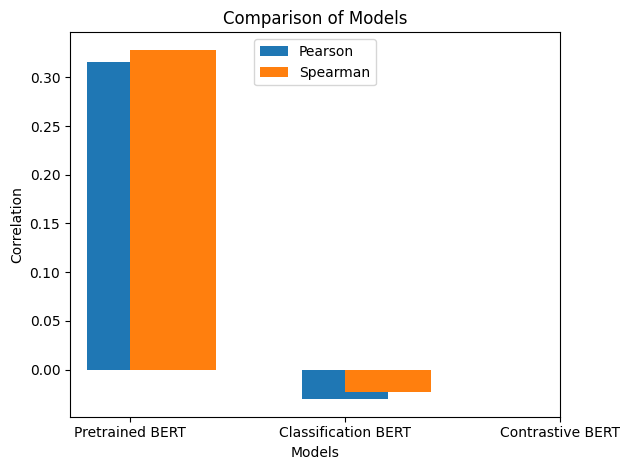

In [ ]:
import matplotlib.pyplot as plt

models = ['Pretrained BERT', 'Classification BERT', 'Contrastive BERT']
pearson_results = [
    results_from_pretrained[0],  # Replace with the Pearson result of pretrained BERT
    result_from_classification[0],  # Replace with the Pearson result of classification BERT
    result_from_contrastive[0]  # Replace with the Pearson result of contrastive BERT
]
spearman_results = [
    results_from_pretrained[1],  # Replace with the Spearman result of pretrained BERT
    result_from_classification[1],  # Replace with the Spearman result of classification BERT
    result_from_contrastive[1]  # Replace with the Spearman result of contrastive BERT
]

x = range(len(models))

plt.bar(x, pearson_results, width=0.4, align='center', label='Pearson')
plt.bar(x, spearman_results, width=0.4, align='edge', label='Spearman')
plt.xlabel('Models')
plt.ylabel('Correlation')
plt.title('Comparison of Models')
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()


# A note by the author:

The correlation is stable for the Pretrained model and the classification based model (though negative in this case), and the results from the contrastive model reflect that the correlation has iterated over constant results which has to do with a substantial problem in the architecture of this trial that I wasn't able to solve on time. Still, I'm grateful for learning this much and being being part of the selection process!